<a href="https://colab.research.google.com/github/kathuman/Python-Experiments/blob/main/220309_Process_Mining1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-1-ae02027a050
import csv

Preparing the Data

In [12]:
import requests
from io import StringIO
import pandas as pd

url = "https://gitlab.com/healthcare2/process-mining-tutorial/-/raw/master/ArtificialPatientTreatment.csv"
# Reading URL, decoding and converting it to pandas dataframe using read_csv
events = pd.read_csv(StringIO(requests.get(url).text), on_bad_lines='skip')
# Printing the first 5 rows of the dataframe
events.head()

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [18]:
events.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [20]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = events.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 
case_starts_ends = case_starts_ends.reset_index() 
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 

In [21]:
# Merge with the main event log data so that for each row we have the start and end times.
events = events.merge(case_starts_ends, on='patient') 

In [36]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   patient        690 non-null    object         
 1    action        690 non-null    object         
 2    org:resource  690 non-null    object         
 3    DateTime      690 non-null    datetime64[ns] 
 4   caseend        690 non-null    datetime64[ns] 
 5   casestart      690 non-null    datetime64[ns] 
 6   relativetime   690 non-null    timedelta64[ns]
dtypes: datetime64[ns](3), object(3), timedelta64[ns](1)
memory usage: 43.1+ KB


In [31]:
events[' DateTime']= pd.to_datetime(events[' DateTime'])
events['caseend']= pd.to_datetime(events['caseend'])
events['casestart']= pd.to_datetime(events['casestart'])

In [34]:
# Calculate the relative time by subtracting the process start time from the event timestamp
events['relativetime'] = events[' DateTime'] - events['casestart']

In [35]:
events.head()

,patient,action,org:resource,DateTime,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


In [46]:
# Convert relative times to more friendly measures
## seconds
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days 
## days
events['relativedays'] = events['relativetime'].dt.days
events['caselength'] = events['caseend'] - events['casestart']

In [47]:
events.head()

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17


Data Analysis

([<matplotlib.axis.YTick at 0x7f22028148d0>,
 <a list of 20 Text major ticklabel objects>)

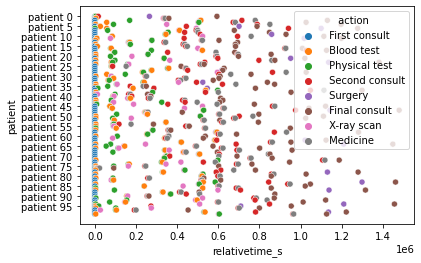

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]
## Plot a scatter plot of patient events over relative time
ax = sns.scatterplot(x=events['relativetime_s'],
y=events['patient'], hue=events[' action'])
## Set y axis ticks so that you only show every 5th patient - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))

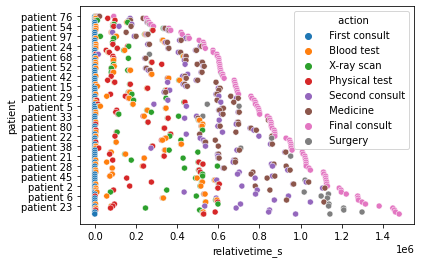

In [50]:
## Order by the case length
ordered = events.sort_values(by=['caselength', 'patient', 'relativetime_s'])
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5)) 
plt.show()

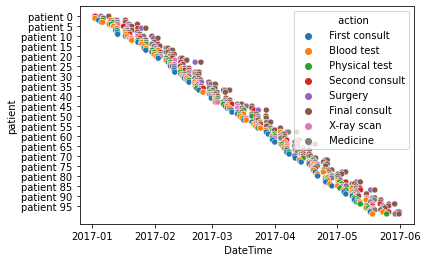

In [51]:
ax = sns.scatterplot(x=events[' DateTime'], y=events['patient'], hue=events[' action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))
plt.show()

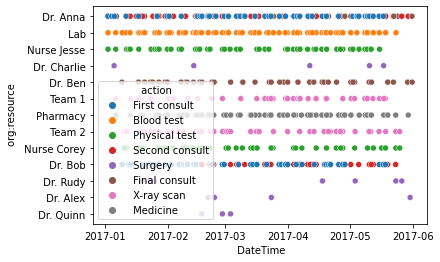

In [52]:
ax = sns.scatterplot(x=events[' DateTime'], y=events[' org:resource'], hue=events[' action'])

In [54]:
## Get day of week 
events['weekday'] = events[' DateTime'].apply(lambda x: x.weekday())

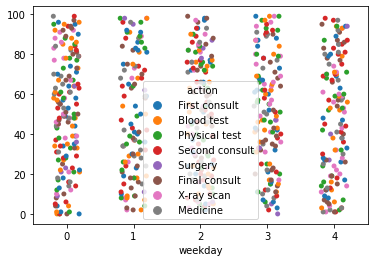

In [55]:
## Strip plot
ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events[' action'], jitter=0.2)

Filtering Events

In [56]:
## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(events['patient'], events[' action']) 
patient_events.head()

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1


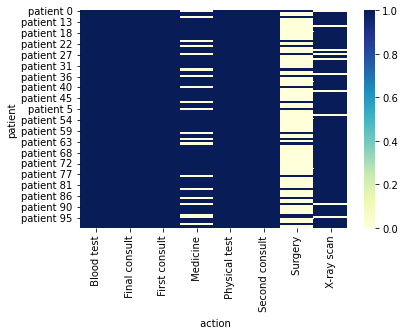

In [57]:
## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")

In [58]:
## Calculate the number of unique event counts 
## This should be 1 for events which are shared by all patients.
nunique = patient_events.apply(pd.Series.nunique) 
## Identify the events which are shared by all 
shared_actions = nunique[nunique==1].index 
actions_to_keep = nunique[nunique>1].index 
print('The following actions are common to all cases: {}'.format(', '.join(shared_actions))) 
print('The following actions are the ones that we wish to keep (not common to all cases): {}'.format(', '.join(actions_to_keep)))

The following actions are common to all cases:  Blood test,  Final consult,  First consult,  Physical test,  Second consult
The following actions are the ones that we wish to keep (not common to all cases):  Medicine,  Surgery,  X-ray scan
